## Notebook (2/2)

In [415]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
# ^^^ pyforest auto-imports - don't write above this line
import pyforest


import os
import warnings
warnings.filterwarnings("ignore")


#importations des modèles de régression : 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR

#importations modèles non linéaires 
from sklearn.kernel_ridge import KernelRidge

#model foret aleatoire :
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# import package de mesure
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error,  mean_squared_log_error, r2_score
from sklearn.metrics.pairwise import rbf_kernel

#import packaging pour mesurer le temps :
import time

#import packaging pour améliorer model : 
from sklearn.model_selection import GridSearchCV, cross_val_score

# Plan : 

## 1.Création des fonctions de modélisation

## 2.Entrainement des modèles

## 3.Comparaison des performance du modèle

## 4.Choix du meilleur modèle et prédiction sur le test

## 5.Soumission du modèle sur kaggle

In [381]:
path = r'D:\\Etude_Data_science\\Kaggle_competition\\05_Regression_with_an_Abalone_Dataset\\datasets\\'
df = pd.read_csv(path+"df_preprocessed.csv")
print("Dimensions : ", df.shape)
df.head()

Dimensions :  (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,0,0.278451,0.289215,0.380989,-0.038218,-0.060561,-0.226889,0.108200,11
1,1,0,0.955902,0.901950,0.249669,0.745840,0.573349,1.063299,0.722954,11
2,2,1,-3.024121,-2.978707,-2.902012,-1.679600,-1.641665,-1.651057,-1.697640,6
3,3,2,0.659517,0.748766,0.380989,0.274531,0.169507,0.358658,0.185044,10
4,4,1,0.320792,0.238153,-0.144291,-0.015254,0.140137,-0.092908,-0.218388,9


In [382]:
X,y = df.drop(["id",'Rings'], axis = 1), df["Rings"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## 1.  Création des fonctions de modélisation

In [383]:

#Création de la fonction d'entrainement d'un modèle
def training_model(model):
    """Création d'une fonction qui entraine un modèle donnée et qui renvoie différentes informations :
    - Affiche le score après une cross validation
    - Renvoi les prédictions du modèle
    - Renvoi la durée d'entrainement du modèle 
    - Renvoi le score (R²)
    - Renvoi le modèle préentrainé
    return : (y_pred, training_time, scoring,  model)
    """
    #Entrainement du modèle sur 5 splits par cross validation :
    scores = cross_val_score(estimator=model, X = X_train, y = y_train,
                             cv=5,scoring="neg_mean_squared_error")

    #Temps début d'entrainement :
    start_time = time.time()
    #Entrainement :
    model.fit(X_train,y_train)
    #Temps fin entrainement
    end_time = time.time()
    # Durée d'entrainement en minute :
    training_time = round((end_time - start_time)/60,2)
    
    #récupération des prédictions du modèle : 
    y_pred = model.predict(X_test)
    
    #Récupération des scores R²
#     scoring = model.score(X_test,y_test)
    
    #Affichage du nom du modèle entrainé : 
    print("\n",type(model).__name__,) 
    print(f"\nAffichage du score sur les {len(scores)} splits :")
    print(f"{[i for i in scores.round(2)]}")
    
    return (y_pred, training_time, model)

In [384]:
def mesure(prediction, model):
    """
    Renvoi un dataframe contenant les valeurs des différentes
    metrics enregistrées à partir des prédicions d'un modèle:
    RMSLE,RMSE, MSE,MAE & R²
    return : Dataframe
    """
    
        # Filtrer les valeurs négatives
    prediction[prediction < 0] = 0

    # Calcul des différentes metrics rmsle,rmse, mae,R²
    log_error = mean_squared_log_error(prediction, y_test)
    rmsle = np.sqrt(log_error)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mse = mean_squared_error(y_test, prediction, squared=True)
    mae = median_absolute_error(y_test, prediction)

    # Calcul du R²
    r2 = r2_score(y_test, prediction)

    # Récupération de l'ensemble des metrics
    all_metric = [rmsle, rmse, mse, mae, r2]
    index_metric = ["RMSLE", "RMSE", "MSE", "MAE", "R²"]

    metric_series = pd.Series(all_metric, name=str(model), index=index_metric)

    return pd.DataFrame(metric_series).T

In [385]:
def visualisation_pred_real(model):
    """
    Fonction qui récupère les prédictions d'un modèle et affiche un graphique en comparant avec les valeurs réelles
    les valeurs réelles sont sur l'axe des x et les valeurs prédites sont sur l'axe des y.
    La ligne rouge en pointillés représente une correspondance parfaite entre les valeurs réelles et prédites. 
    Dans un modèle parfait, tous les points se situeraient le long de cette ligne.
    return : scatterplot
    """
    # Supposons que y_test contient les vraies valeurs et y_pred contient les valeurs prédites par votre modèle
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 4))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5) #scatterplot avec les vraies valeurs en x et les valeurs prédites en y

    # Ajouter une ligne diagonale pour indiquer une correspondance parfaite entre les valeurs réelles et prédites
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    # Label et  titre
    plt.title('Scatter Plot des Valeurs Réelles vs. Prédites')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.show()


In [386]:
def graphic(dictionnary_metric):
    """ fonction qui renvoie directement les graphiques contenant les mesures des performances d'un modèle"""
    
    #Transformation du dictionnaire des metrics en un dataframe complet :
    metric_df = pd.concat(dictionnary_metric.values(), axis = 1)
    # Réinitialisation d'abord de l'index pour convertir l'index en colonne
    metric_df_reset = metric_df.reset_index()

    # Ensuite, ON utilise melt avec le nouvel index comme id_vars
    metric_df_melt = metric_df_reset.melt(id_vars="index", var_name="Model", value_name="Score")
    
    plt.figure(figsize=(10,6))
    plt.grid()
    sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Comparaison des scores des modèles')
    plt.show()

In [387]:
### Fonction permettant d'améliorer un modèle grâce au GridSearchCV :

def Grid(model, param):
    """Le modèle sera entrainé sur 5 splits
    et renverra les prédictions du meilleur modèles ainsi que son temps d'entrainement"""
    
 # Mesurer le temps de début
    start_time = time.time()
        
    #Entrainement du grid sur les paramètres
    grid = GridSearchCV(estimator=model, param_grid=param, cv=5)
    grid.fit(X_train, y_train)
    # Mesurer le temps de fin
    end_time = time.time()
    
    #Recuperation des meilleurs hyper parametres :
    best_model = grid.best_estimator_
    
    # Convertir X_test en un format compatible si nécessaire
    X_test_transformed = X_test.values  

    
    #Recuperation des predictions
    yp = best_model.predict(X_test_transformed)
    
    #Calcul temps d'execution:
    training_time = round(end_time- start_time  , 3)
    #On converti en minutes :
    training_time_min = round(training_time/60,2)
    
    return yp, training_time_min, best_model

In [416]:
#Selection des modèles :
model_selected = [
                DummyRegressor(strategy="mean"), 
                LinearRegression(),
                LinearSVR(),
                Ridge(),
                Lasso(),
                RandomForestRegressor(),
                GradientBoostingRegressor(),
                XGBRegressor(),
                LGBMRegressor()
                 ]

In [417]:
#Création des dictionnaires qui contiendront différentes informations :
dict_model = {} #contiendra les modèles préentrainés
dict_time = {} #contiendra les durées d'entrainement
dict_pred =  {} #contiendra les prédictions
dict_scoring = {} #contiendra les différents scores sur le test set (R²)
dict_metric = {} #contiendra les différentes metrics

## 2. Entrainement des modèles

In [418]:
#Création d'une boucle qui parcours l'ensemble des modèles selectionnés

for temp_model in model_selected:
    #récupérer le nom du modèle : 
    nom_model = type(temp_model).__name__
    
    pred, timing, model = training_model(temp_model) #récupération des prédictions, temps et du modèle 
    
    dict_pred[nom_model] = pred #récupération des prédictions
    dict_time[nom_model] = timing #récupération du temps d'entrainement
    dict_scoring[nom_model] = scoring #récupération des scores R²
    dict_model[nom_model] = model #récupération du modèle préentrainé
    
    # Pour les metrics :
    dict_metric[nom_model] = mesure(pred, nom_model) #ajout des metrics de notre fonction (MAE,RMSE,MSE)
    dict_metric[nom_model]["time"] = timing #rajout d'une colonne contenant le temps d'entrainement
    dict_metric[nom_model] = dict_metric[nom_model].T #inversion colonne/index pour faciliter la lecture


 DummyRegressor

Affichage du score sur les 5 splits :
[-9.96, -10.16, -9.96, -10.27, -9.86]

 LinearRegression

Affichage du score sur les 5 splits :
[-3.98, -4.1, -3.99, -4.1, -3.9]

 LinearSVR

Affichage du score sur les 5 splits :
[-4.12, -4.29, -4.18, -4.32, -4.07]

 Ridge

Affichage du score sur les 5 splits :
[-3.98, -4.1, -3.99, -4.1, -3.9]

 Lasso

Affichage du score sur les 5 splits :
[-6.04, -6.29, -6.11, -6.34, -5.98]

 RandomForestRegressor

Affichage du score sur les 5 splits :
[-3.52, -3.58, -3.5, -3.6, -3.48]

 GradientBoostingRegressor

Affichage du score sur les 5 splits :
[-3.48, -3.6, -3.54, -3.59, -3.42]

 XGBRegressor

Affichage du score sur les 5 splits :
[-3.45, -3.51, -3.43, -3.54, -3.39]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1329


## 3. Comparaison des performances des modèles

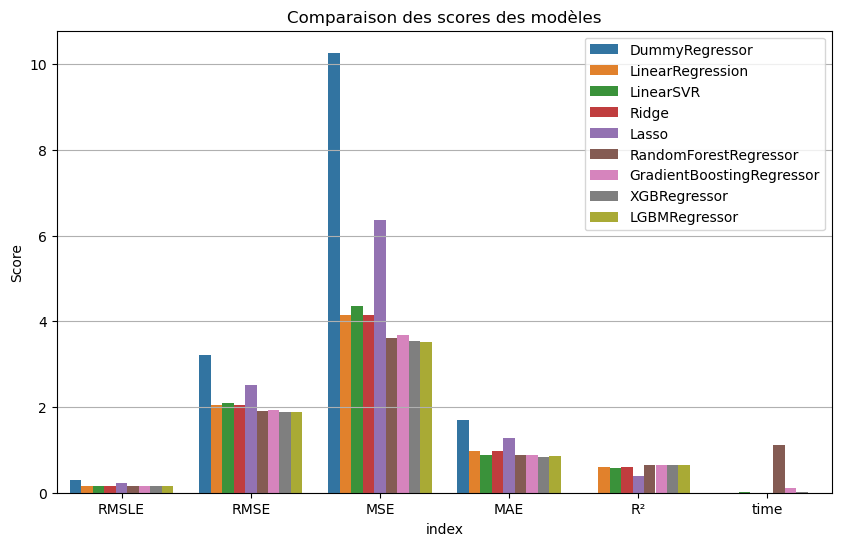

In [419]:
graphic(dict_metric)


DummyRegressor


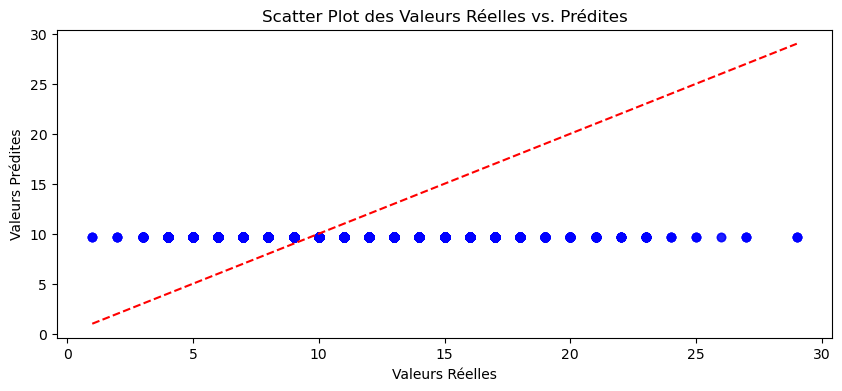

LinearRegression


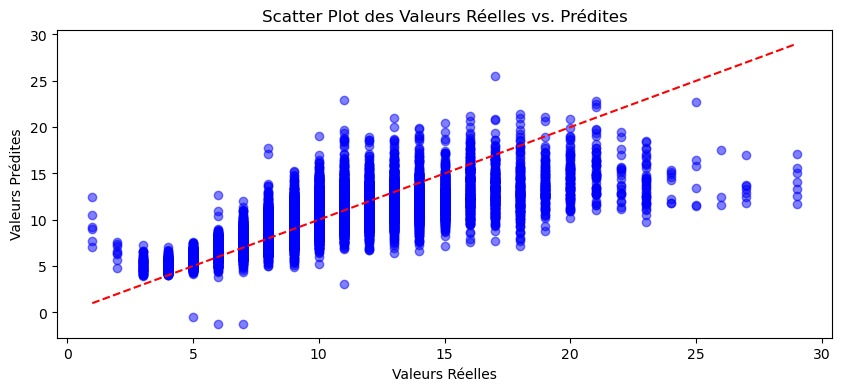

LinearSVR


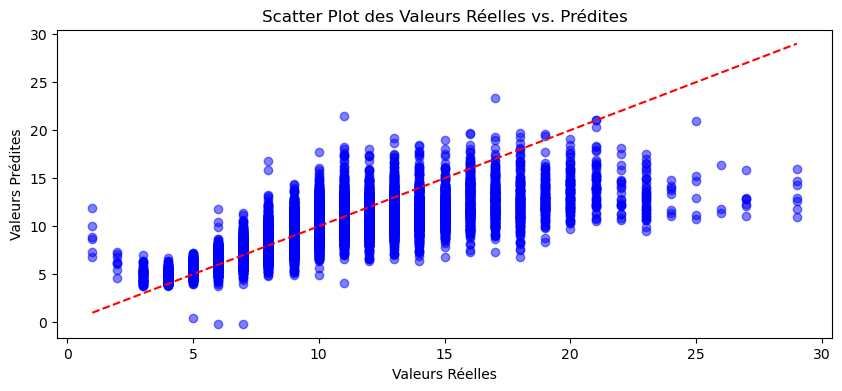

Ridge


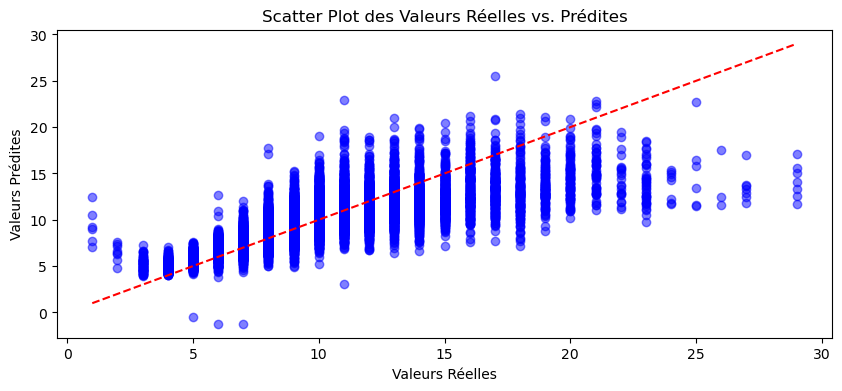

Lasso


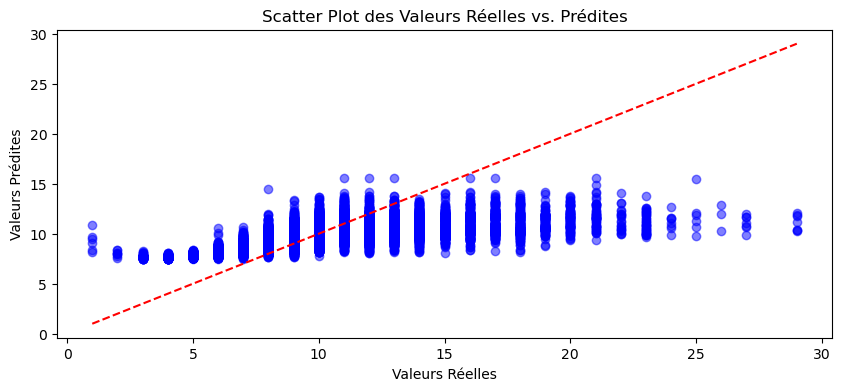

RandomForestRegressor


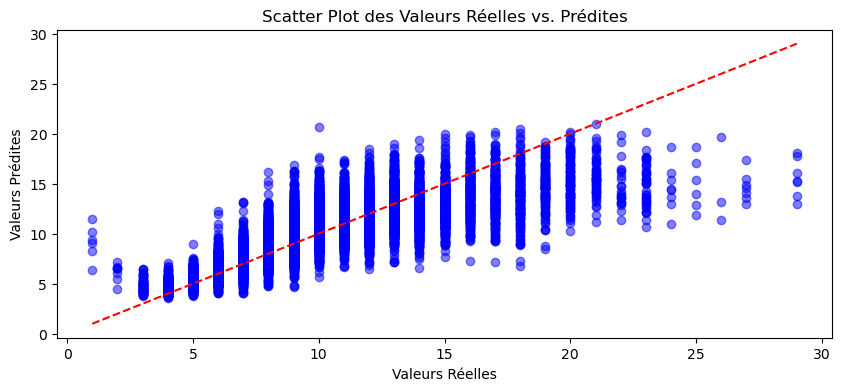

GradientBoostingRegressor


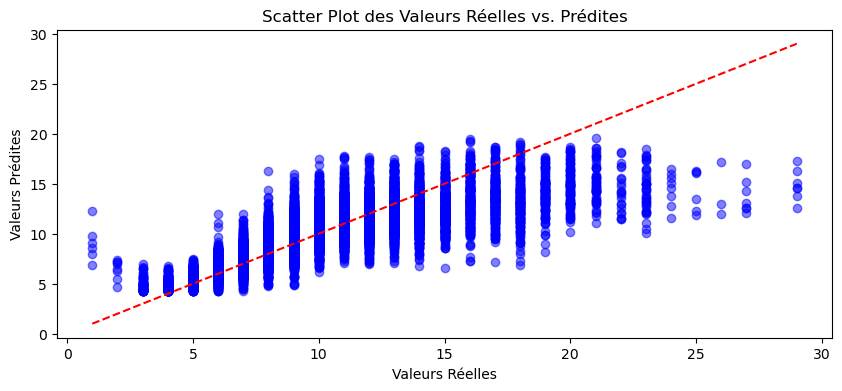

XGBRegressor


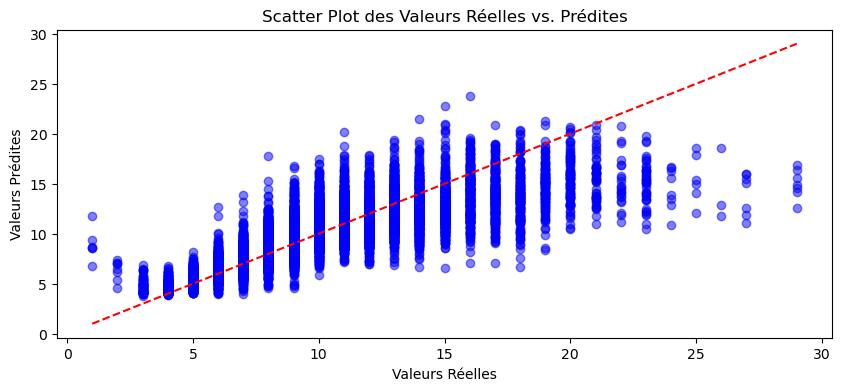

LGBMRegressor


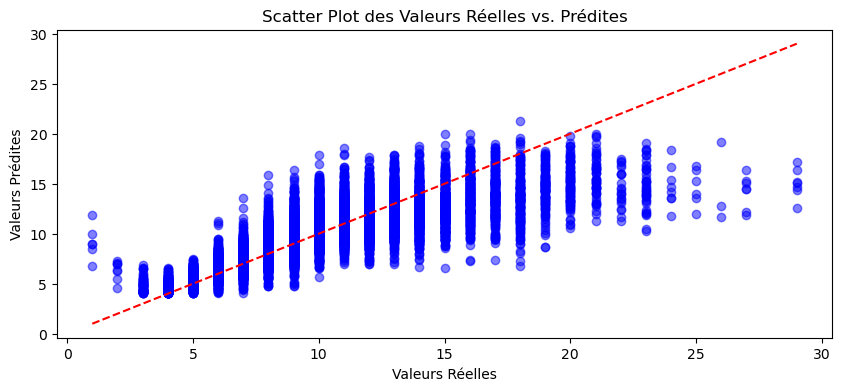

In [421]:
for i in dict_model:
    print(i)
    visualisation_pred_real(dict_model[i])

## 4. Choix du modèle : 
- Au vu des résultats, le modèle **RandomForestRegressor & XGBRegressor** proposent les meilleurs résultat avec la RMSLE la plus faible, avec le temps d'entrainement le plus élevé (pour randomforest uniquement)

## 5. Soumission du modèle sur kaggle
### RandomForest :
- Pour cela, il va falloir **prétraiter** un jeu de données inconnus

In [422]:
#Chargement des prepropressed entrainé : 

#Encoder
with open("labelencoder.pkl", "rb") as f:
    encoder = pickle.load(f)
#Standardscaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)


In [423]:
newdf = pd.read_csv(path+"test.csv")
print("Dimensions : ", newdf.shape)
newdf.head()

Dimensions :  (60411, 9)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [424]:
def prediction(new_data, model):
    """Fonction qui prend en entrée un dataframe, un modèle 
    renvoie un dataframe contenant les prédiction 
    La fonction va effectuer tout le preprocessing pour de nouvelles données
    """
        ### on va garder l'id en parallele : 
    identifiant = new_data.id
    new_data = new_data.drop(identifiant.name, axis = 1)
    
    #Colonnes qui ont servis à l'entrainement du modèle : 
    training_col = [
        "Sex","Length","Diameter","Height","Whole weight",
        "Whole weight.1","Whole weight.2","Shell weight"
                   ]
    #Séparation des colonnes en fonction du type
    var_cont = list(new_data.select_dtypes(exclude="object").columns)
    var_qual = list(new_data.select_dtypes(include="object"))

    #On filtre pour récupérer uniquement les mêmes colonnes qui ont été utilisés pendant l'entrainement du modèle :
    new_data = new_data[training_col]
    
    #Preprocessing :
        #StandardScaler:
    df_standardized = pd.DataFrame(scaler.transform(new_data[var_cont]), 
                                   columns = new_data[var_cont].columns)
        #Encoder : 
    df_encoded = pd.DataFrame(encoder.transform(new_data[var_qual]), 
                              columns = new_data[var_qual].columns)
    
    #fusion des deux dataframe :
    df_transformed = pd.concat([df_encoded, df_standardized], axis = 1)
    
    #Remettons les colonnes dans l'ordre d'origine :
    df_transformed = df_transformed[training_col]
    
        #Ensuite on peut prendre les prédiction du modèle : 
    prediction = np.round(model.predict(df_transformed)) #On arrondie les prédictions pour avoir le meme format qu'attendu:
    #c'est à dire des prédictions avec des valeurs entières
    prediction_df  = pd.DataFrame(prediction, 
                                                 columns=["Rings"],
                                  index = identifiant
            )
    return prediction_df

In [425]:
final_model = dict_model['RandomForestRegressor']

In [426]:
prediction_newdata = prediction(newdf, final_model)

#### Enregistrement du tableau et soumission a kaggle

In [427]:
prediction_newdata.to_csv("prediction_RandomForest_kaggle.csv")

## Résultats obtenus :
- Avec le randomforest nous avons obtenu un score de : 0.15551
- Le meilleur score obtenu est : 0.14370 

La différence est très faible, nous pourrions essayer d'améliorer notre score (pour rappel plus il est proche de 0 et mieux il est) en utilisant un **GridSearchCV**

## Amélioration par GridSearchCV 
###  XGBRegressor:


In [405]:
# Définition des paramètres de la grille
param_grid = {
    'n_estimators': [100, 200, 300],  # Nombre d'arbres dans le modèle
     'max_depth': [3, 4, 5],  # Profondeur maximale de chaque arbre
     'learning_rate': [0.05, 0.1, 0.2],  # Taux d'apprentissage
#     'min_child_weight': [1, 3, 5],  # Poids minimum des enfants (minimum sum of instance weight(hessian) needed in a child)
     'gamma': [0, 0.1, 0.2],  # Réduction de la perte minimale requise pour effectuer une partition sur une feuille
#     'subsample': [0.8, 1.0],  # Proportion des échantillons utilisés pour entraîner chaque arbre
#     'colsample_bytree': [0.8, 1.0],  # Proportion des colonnes utilisées pour entraîner chaque arbre
#     'reg_alpha': [0, 0.1, 0.5],  # Terme de régularisation L1 sur les poids des feuilles
#     'reg_lambda': [0, 0.1, 0.5]  # Terme de régularisation L2 sur les poids des feuilles
}


In [406]:
pred_grid, time_grid, best_model_grid = Grid(XGBRegressor(), param=param_grid)

- Les meilleurs paramètres sont équivalent au XGBRegressor de base sans modification
- On pourrait toucher à d'autres paramètres afin d'améliorer les performances **max_depth, learning_rate, etc.** Mais cela est très chronophage, nous allons ici nous contenter de notre XGB sans hypertuning via Grid et le déposer sur kaggle

# Mesure des nouvelles performances : 

In [407]:
    # Pour les metrics :
dict_metric["XGB_grid"] = mesure(pred_grid, "XGB_grid") #ajout des metrics de notre fonction (MAE,RMSE,MSE)
dict_metric["XGB_grid"]["time"] = time_grid #rajout d'une colonne contenant le temps d'entrainement
dict_metric["XGB_grid"] = dict_metric["XGB_grid"].T #inversion colonne/index pour faciliter la lecture

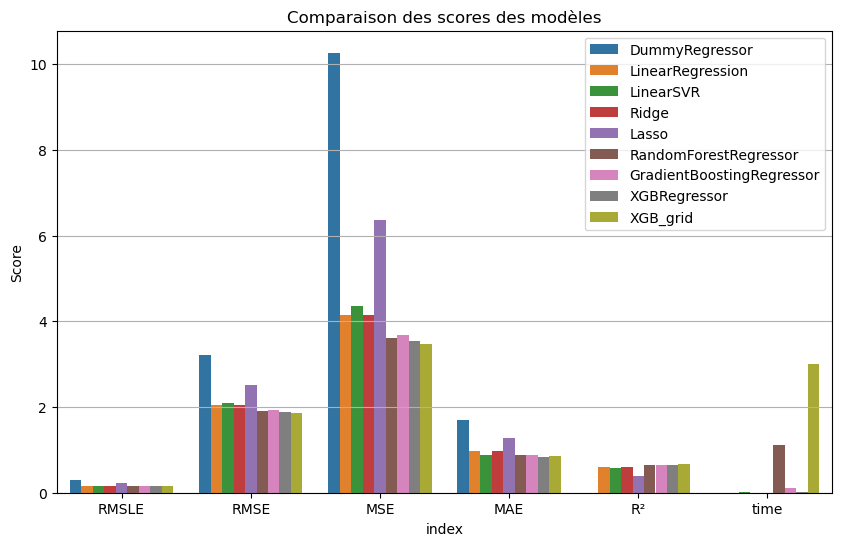

In [408]:
graphic(dict_metric)

- On peut voir qu'avec le XGBRegressor Grid on a un léger mieux par rapport a son homologue sans Grid. 
- MAJ : après avoir soumis les résultats, le score est meilleur en utilisant le XGN sans grid

In [428]:
dict_model

{'DummyRegressor': DummyRegressor(),
 'LinearRegression': LinearRegression(),
 'LinearSVR': LinearSVR(),
 'Ridge': Ridge(),
 'Lasso': Lasso(),
 'RandomForestRegressor': RandomForestRegressor(),
 'GradientBoostingRegressor': GradientBoostingRegressor(),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=Non

In [429]:
model_XGB = dict_model['XGB_grid']
prediction_newdata_XGB = prediction(newdf, model_XGB)

In [430]:
#Enregistrement et soumission a kaggle
prediction_newdata.to_csv("prediction_LGBM_kaggle.csv")

## Résultats : 

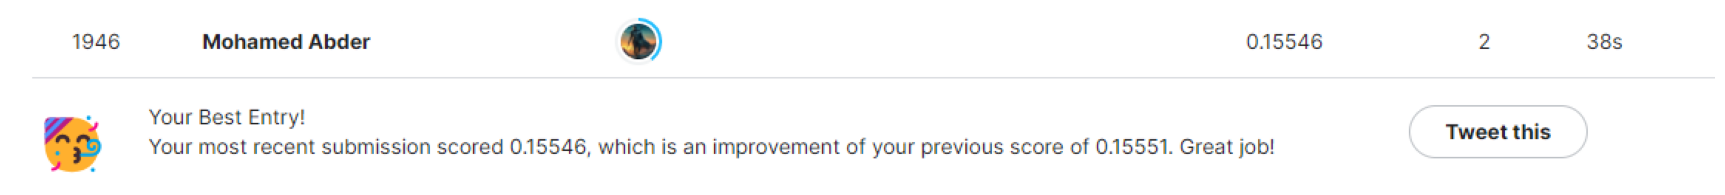

In [377]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Chemin de l'image
image_path = "score_kaggle.png"
# Chargement de l'image
image = mpimg.imread(image_path)
plt.figure(figsize=(22, 16))
# Affichage de l'image
plt.imshow(image)
plt.axis('off')  # Optionnel : pour masquer les axes
plt.show()


#### Nous pouvons voir que nous avons obtenu un score plus bas (et donc de meilleur performances)